In [7]:
# Set the process name to be human readable in htop
import setproctitle
setproctitle.setproctitle("Prep_Figure_4")

import requests
import pandas as pd
pd.options.display.max_columns = 999

import numpy as np
import helper as my

import glob
import os
import sys

from tqdm import tqdm, tqdm_notebook
from tqdm._tqdm_notebook import tqdm_notebook

tqdm.pandas(tqdm_notebook)
tqdm_notebook.pandas()


%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

from collections import defaultdict
import math

In [197]:
ires = pd.read_csv("../../Data/Interface_Summary.txt", sep="\t")
print ires[ires["Source"] == "Docking"]["P1_Ires"].map(lambda x: len(x.split(",")) if type(x) == str else 0).mean()
print ires[ires["Source"] == "Docking"]["P2_Ires"].map(lambda x: len(x.split(",")) if type(x) == str else 0).mean()

18.164
17.932


In [199]:
p2ires = defaultdict(set)
for p1, ires1 in ires[ires["Source"] == "Docking"][["P2", "P2_Ires"]].values:
    if(type(ires1) == float):
        #p2ires[p1]
        continue
    if("-" in ires1):
        print "A"
    p2ires[p1].update(set(ires1.split(",")))
print sum([len(v) for v in p2ires.values()])
print len(p2ires)

4483
250


# Fetch and create PyMol Sessions for ddG Mutated Structures

In [10]:
ddG_summary = pd.read_csv("../../Data/ddG_Summary.txt", sep="\t")

In [11]:
candidates = ddG_summary[(ddG_summary["p-value"] <= 0.05)&(ddG_summary["ddG"].abs() >= 1)].sort_values("ddG", ascending=False)

In [12]:
proteins = pd.read_csv("../../Data/Proteins.txt", sep="\t")
uni2seq = proteins.set_index("ID")["Sequence"].to_dict()
uni2gene = proteins.set_index("ID")["Gene_Name"].to_dict()

In [13]:
ires_df = pd.read_csv("../../Data/Interface_Summary.txt", sep="\t")
ires_df = ires_df.sort_values(["P1", "P2", "Source"]).drop_duplicates(["P1", "P2"])
inter2ires = ires_df.set_index(["P1", "P2"])[["P1_Ires", "P2_Ires"]].to_dict(orient="index")

In [14]:
viral_muts = pd.read_csv("../../Data/Viral_Muts.txt", sep="\t")

In [15]:
def fetch_scores_from_pdb(pdb, pdb_df=None, relabel=True):
    if(relabel and (pdb_df is None)):
        pdb_df = my.pdb2df(pdb)
    
    lines = my.easyReadLines(pdb)
    keep = []
    flag = True
    for l in lines:
        if(flag and not "#BEGIN" in l):
            continue
        else:
            flag = False
            keep.append(l)
    scores1 = pd.DataFrame([x.split() for x in keep[3:-2]], columns=keep[1].split())
    
    if(relabel):
        scores1["Chain"] = ["NA"] + pdb_df.drop_duplicates(["Chain", "Residue ID"])["Chain"].to_list()
        scores1["Res"] = ["NA"] + pdb_df.drop_duplicates(["Chain", "Residue ID"])["Residue Name"].to_list()
        scores1["Resi"] = ["NA"] + pdb_df.drop_duplicates(["Chain", "Residue ID"])["Residue ID"].to_list()
        
        scores1 = scores1[["Chain", "Res", "Resi"] + list(scores1)[1:-3]]
    
    return scores1
# FUNCTION END

def calc_ddG_per_residue(base, pdb_df=None):
    wt_comp = sorted(glob.glob("{0}_*WT_Complex.pdb".format(base)))
    mut_comp = sorted(glob.glob("{0}_*Mut_Complex.pdb".format(base)))
    wt_sep = sorted(glob.glob("{0}_*WT_Separate.pdb".format(base)))
    mut_sep = sorted(glob.glob("{0}_*Mut_Separate.pdb".format(base)))
    
    pdb_df = my.pdb2df(wt_comp[0])
    
    trials = []
    for wt_c, wt_sep, mut_c, mut_sep in zip(wt_comp, wt_sep, mut_comp, mut_sep):
        a = fetch_scores_from_pdb(wt_c, relabel=False)
        b = fetch_scores_from_pdb(wt_sep, relabel=False)
        
        c = fetch_scores_from_pdb(mut_c, relabel=False)
        d = fetch_scores_from_pdb(mut_sep, relabel=False)
        
        ddg = (c[list(c)[1:]].astype(float) - d[list(d)[1:]].astype(float)) - (a[list(a)[1:]].astype(float) - b[list(b)[1:]].astype(float))
        
        trials.append(ddg)
    ddg = sum(trials) / float(len(trials))
    
    ddg["Chain"] = ["NA"] + pdb_df.drop_duplicates(["Chain", "Residue ID"])["Chain"].to_list()
    ddg["Res"] = ["NA"] + pdb_df.drop_duplicates(["Chain", "Residue ID"])["Residue Name"].to_list()
    ddg["Resi"] = ["NA"] + pdb_df.drop_duplicates(["Chain", "Residue ID"])["Residue ID"].to_list()
    
    ddg = ddg[["Chain", "Res", "Resi"] + list(ddg)[:-3]]
    
    return ddg
# FUNCTION END

In [16]:
import __main__
__main__.pymol_argv = ['pymol','-cqk'] # Pymol: quiet and no GUI

import pymol
pymol.finish_launching()
from pymol import cmd as pymolCmd

In [17]:
def polarpairs(sel1, sel2, cutoff=4.0, angle=63.0, name='', state=1, quiet=1):
    '''
ARGUMENTS

    sel1, sel2 = string: atom selections

    cutoff = float: distance cutoff

    angle = float: h-bond angle cutoff in degrees. If angle="default", take
    "h_bond_max_angle" setting. If angle=0, do not detect h-bonding.

    name = string: If given, also create a distance object for visual representation

SEE ALSO

    pymolCmd.find_pairs, pymolCmd.distance
    '''
    cutoff = float(cutoff)
    quiet = int(quiet)
    state = int(state)
    if angle == 'default':
        angle = pymolCmd.get('h_bond_max_angle', pymolCmd.get_object_list(sel1)[0])
    angle = float(angle)
    mode = 1 if angle > 0 else 0
    x = pymolCmd.find_pairs('(%s) and donors' % sel1, '(%s) and acceptors' % sel2,
            state, state,
            cutoff=cutoff, mode=mode, angle=angle) + \
        pymolCmd.find_pairs('(%s) and acceptors' % sel1, '(%s) and donors' % sel2,
            state, state,
            cutoff=cutoff, mode=mode, angle=angle)
    x = sorted(set(x))
    if not quiet:
        print('Settings: cutoff=%.1fangstrom angle=%.1fdegree' % (cutoff, angle))
        print('Found %d polar contacts' % (len(x)))
    if len(name) > 0:
        for p in x:
            pymolCmd.distance(name, '(%s`%s)' % p[0], '(%s`%s)' % p[1])
    return x
# FUNCTION END

pymolCmd.extend('polarpairs', polarpairs)

<function __main__.polarpairs>

In [36]:
#inter2ddG = defaultdict()
for p1, p2, ddG, pdb_file in tqdm_notebook(candidates[["P1", "P2", "ddG", "pdbfile"]].values):
    if(not p2 in ["Q9Y375", "Q9Y3A6", "P52948", "Q9NXA8", "O94826"]):
        continue
    #else:
    #    os.system("ls ../../Data/ddG_Mutated_Structures/All_Structures/COVID19{0}_{1}/".format(p1, p2))
    #    continue
    print p1, p2
    if(os.path.exists("../../" + pdb_file.replace(".pdb", "Mut_Complex.pdb"))):
        print "Exits"
        pdb_file = "../../" + pdb_file
    else:
        print "Does not Exist"
        pdb_file = "../../Data/ddG_Mutated_Structures/All_Structures/COVID19{0}_{1}/".format(p1, p2) + os.path.basename(pdb_file)
    pymolCmd.reinitialize()
    
    #mut_struc = pdb_file
    #docked_struc = glob.glob("../../Data/Docked_Structures/*{0}*{1}_top_dock.pdb".format(p1, p2))[0]
    docked_struc = pdb_file.replace(".pdb", "WT_Complex.pdb")
    mut_struc = pdb_file.replace(".pdb", "Mut_Complex.pdb")
    
    p2_name = uni2gene[p2]
    print p2_name
    
    # Calc ddG
    print "Calc ddG"
    #ddg = calc_ddG_per_residue("../../Data/ddG_Mutated_Structures/All_Structures/COVID19{0}_{1}/{2}".format(p1, p2, os.path.basename(pdb_file).split("_Muts")[0]))
    print pdb_file.split("_Muts")[0]
    if("_".join([p1, p2]) in inter2ddG):
        ddg_df = inter2ddG["_".join([p1, p2])]
    else:
        1/0
        ddg_df = calc_ddG_per_residue(pdb_file.split("_Muts")[0])
        ddg_df[["fa_atr", "fa_rep", "fa_sol", "hbond_bb_sc", "hbond_sc", "total"]] = -1*ddg_df[["fa_atr", "fa_rep", "fa_sol", "hbond_bb_sc", "hbond_sc", "total"]]
        inter2ddG["_".join([p1, p2])] = ddg_df
    
    # Load docked / mutated structures
    print "Loading"
    pymolCmd.load(docked_struc, p1 + "_COVID")
    print "1"
    pymolCmd.extract(p2 + "_COVID", p1 + "_COVID and chain B")
    
    print "2"
    pymolCmd.load(mut_struc, p1 + "_SARS")
    print "3"
    pymolCmd.align(p1 + "_SARS", p1 + "_COVID")
    print "4"
    pymolCmd.extract(p2 + "_SARS", p1 + "_SARS and chain B")
    
    
    # Remove Hydrogens
    print "5"
    pymolCmd.extract(ddG, "element h")
    
    
    # Initial Pymol Display Settings / Colors
    print "Initializeing"
    pymolCmd.hide("everything")
    pymolCmd.show("cartoon")
    cmapA = matplotlib.cm.Blues
    cmapB = matplotlib.cm.Greens
    pymolCmd.color(matplotlib.colors.rgb2hex(cmapA(0.24)[:3]).replace("#", "0x"), "chain A")
    pymolCmd.color(matplotlib.colors.rgb2hex(cmapB(0.24)[:3]).replace("#", "0x"), "chain B")
    
    # Color Interface Residues
    print "Ires"
    ires_A = str(inter2ires[("COVID19" + p1, p2)]["P1_Ires"])
    ires_A_sele = " and (resi " + " or resi ".join([str(int(x)) for x in ires_A.split(",") if not x == "nan"]) + ")"
    #pymolCmd.color(matplotlib.colors.rgb2hex(cmapA(0.48)[:3]).replace("#", "0x"), "chain A " + ires_A_sele)
    #pymolCmd.show("lines", "chain A " + ires_A_sele) # AND BACKBONE OR CA
    
    ires_B = inter2ires[("COVID19" + p1, p2)]["P2_Ires"]
    ires_B_sele = " and (resi " + " or resi ".join([str(int(x)) for x in ires_B.split(",") if not x == "nan"]) + ")"
    #pymolCmd.color(matplotlib.colors.rgb2hex(cmapB(0.48)[:3]).replace("#", "0x"), "chain B " + ires_B_sele)
    #pymolCmd.show("lines", "chain B " + ires_B_sele) # AND BACKBONE OR CA
    
    
    # Label Viral Muts
    print "Label Muts"
    muts = viral_muts[viral_muts["COVID_ID"] == "COVID19" + p1]["COVID_Pos"].to_list()
    mut_sele = "and (resi " + " or resi ".join([str(int(x)) for x in muts]) + ")"
    pymolCmd.copy_to(p1 + "_COVID_Muts", p1 + "_COVID " + mut_sele)
    pymolCmd.copy_to(p1 + "_SARS_Muts", p1 + "_SARS " + mut_sele)
    pymolCmd.show("sticks", p1 + "_COVID_Muts")
    #pymolCmd.show("spheres", p1 + "_COVID_Muts and name CA")
    pymolCmd.show("sticks", p1 + "_SARS_Muts")
    pymolCmd.show("spheres", p1 + "_SARS_Muts and name CA")
    pymolCmd.color("magenta", p1 + "_SARS_Muts")
    pymolCmd.color("firebrick", p1 + "_SARS_Muts and name CA")
    
    
    # Flag Polar Contacts
    print "Polar Contacts"
    pairs1 = polarpairs(p1 + "_COVID", p2 + "_COVID", name="COVID_Polar_Contacts")
    pairs2 = polarpairs(p1 + "_SARS", p2 + "_SARS", name="SARS_Polar_Contacts")
    if(len(pairs1)):
        pymolCmd.hide("labels", "COVID_Polar_Contacts")
    if(len(pairs2)):
        pymolCmd.hide("labels", "SARS_Polar_Contacts")
    
    # Color interface by ddG
    vmax = math.ceil(abs(max(ddg_df["total"][1:], key=lambda x: abs(x))))
    if(p2 == "Q9Y3A6" or p2 == "Q9Y375"):
        vmax = 5
    print "vmax:", vmax
    show_resis = [[], []]
    cmapddG = lambda x: matplotlib.cm.seismic(float((x + vmax)) / (vmax*2.0)) if abs(x != vmax) else matplotlib.cm.seismic([0.0, 1.0][x > 0])
    for chain, resi, delta in ddg_df[["Chain", "Resi", "total"]].values:
        if(chain == "A" and (int(resi) in [int(x) for x in str(ires_A).split(",") if not x == "nan"] or abs(delta) >= 0.1)):
            if(abs(delta) >= 0.1):
                show_resis[0].append(str(int(resi)))
            pymolCmd.color(matplotlib.colors.rgb2hex(cmapddG(delta)[:3]).replace("#", "0x"), p1 + "_COVID and resi {0}".format(resi))
            pymolCmd.color(matplotlib.colors.rgb2hex(cmapddG(-delta)[:3]).replace("#", "0x"), p1 + "_SARS and resi {0}".format(resi))
        if(chain == "B" and (int(resi) in [int(x) for x in str(ires_B).split(",") if not x == "nan"] or abs(delta) >= 0.1)):
            if(abs(delta) >= 0.1):
                show_resis[1].append(str(int(resi)))
            pymolCmd.color(matplotlib.colors.rgb2hex(cmapddG(delta)[:3]).replace("#", "0x"), p2 + "_COVID and resi {0}".format(resi))
            pymolCmd.color(matplotlib.colors.rgb2hex(cmapddG(-delta)[:3]).replace("#", "0x"), p2 + "_SARS and resi {0}".format(resi))
    
    pymolCmd.color("atomic", "not element C")
    
    # Create Super Surface
    pymolCmd.copy_to(p1 + "_COVID_SURFACE", p1 + "_COVID")
    pymolCmd.copy_to(p2 + "_COVID_SURFACE", p2 + "_COVID")
    pymolCmd.copy_to(p1 + "_SARS_SURFACE", p1 + "_SARS")
    pymolCmd.copy_to(p2 + "_SARS_SURFACE", p2 + "_SARS")
    surface_sele = "(" + p1 + "_COVID_SURFACE" + " or " + p2 + "_COVID_SURFACE" + " or " + p1 + "_SARS_SURFACE" + " or " + p2 + "_SARS_SURFACE" + ")"
    pymolCmd.hide("everything", surface_sele)
    pymolCmd.color(matplotlib.colors.rgb2hex(cmapA(0.24)[:3]).replace("#", "0x"), surface_sele + " and chain A")
    pymolCmd.color(matplotlib.colors.rgb2hex(cmapB(0.24)[:3]).replace("#", "0x"), surface_sele + " and chain B")
    pymolCmd.color(matplotlib.colors.rgb2hex(cmapA(0.48)[:3]).replace("#", "0x"), surface_sele + " and chain A " + ires_A_sele)
    pymolCmd.color(matplotlib.colors.rgb2hex(cmapB(0.48)[:3]).replace("#", "0x"), surface_sele + " and chain B " + ires_B_sele)
    pymolCmd.show("surface", surface_sele)
    
    
    # Hide irrelevant shit
    if(len(show_resis[0]) != 0):
        pymolCmd.select("A", p1 + "_COVID" + " and (resi {0})".format(" or resi ".join(show_resis[0])))
    else:
        pymolCmd.select("A", "element Z" )
    if(len(show_resis[1]) != 0):
        pymolCmd.select("B", p2 + "_COVID" + " and (resi {0})".format(" or resi ".join(show_resis[1])))
    else:
        pymolCmd.select("B", "element Z" )
    if(len(show_resis[0]) != 0):
        pymolCmd.select("C", p1 + "_SARS" + " and (resi {0})".format(" or resi ".join(show_resis[0])))
    else:
        pymolCmd.select("C", "element Z" )
    if(len(show_resis[1]) != 0):
        pymolCmd.select("D", p2 + "_SARS" + " and (resi {0})".format(" or resi ".join(show_resis[1])))
    else:
        pymolCmd.select("D", "element Z" )
    pymolCmd.select("Hide_Sele", "not ((byresi all within 6 of (chain A {0})) or (byresi all within 6 of (chain B {1})))".format(ires_A_sele, ires_B_sele))
    
    # Save Session
    print "Save"
    pymolCmd.save("ddG_Sessions/{0}_{1}_{2:0.2f}.pse".format(p1, p2_name, ddG))
    print

orf6 P52948
Does not Exist
NUP98
Calc ddG
../../Data/ddG_Mutated_Structures/All_Structures/COVID19orf6_P52948/COVID19orf6_P52948_1_SARS
Loading
1
2
3
4
5
Initializeing
Ires
Label Muts
Polar Contacts
vmax: 2.0
Save

nsp14 Q9NXA8
Does not Exist
SIRT5
Calc ddG
../../Data/ddG_Mutated_Structures/All_Structures/COVID19nsp14_Q9NXA8/COVID19nsp14_Q9NXA8_1_SARS
Loading
1
2
3
4
5
Initializeing
Ires
Label Muts
Polar Contacts
vmax: 3.0
Save

orf9b O94826
Does not Exist
TOMM70
Calc ddG
../../Data/ddG_Mutated_Structures/All_Structures/COVID19orf9b_O94826/COVID19orf9b_O94826_1_SARS
Loading
1
2
3
4
5
Initializeing
Ires
Label Muts
Polar Contacts
vmax: 5.0
Save

orf9c Q9Y3A6
Does not Exist
TMED5
Calc ddG
../../Data/ddG_Mutated_Structures/All_Structures/COVID19orf9c_Q9Y3A6/COVID19orf9c_Q9Y3A6_1_SARS
Loading
1
2
3
4
5
Initializeing
Ires
Label Muts
Polar Contacts
vmax: 5
Save

orf9c Q9Y375
Does not Exist
NDUFAF1
Calc ddG
../../Data/ddG_Mutated_Structures/All_Structures/COVID19orf9c_Q9Y375/COVID19orf9c_Q9Y37

In [38]:
0

0

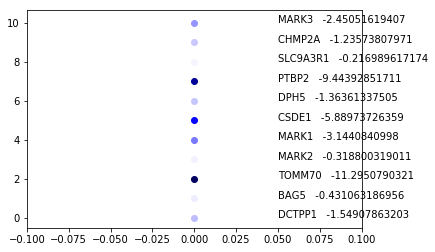

In [74]:
vmax = 12
cmapddG = lambda x: matplotlib.cm.seismic(float((x + vmax)) / (vmax*2.0)) if abs(x != vmax) else matplotlib.cm.seismic([0.0, 1.0][x > 0])
i = 0
for p2, ddG_val in sorted(ddG_summary[ddG_summary["P1"] == "orf9b"][["P2", "ddG"]].values, key=lambda x: np.random.random()):
    plt.scatter(0, i, color=cmapddG(ddG_val))
    plt.text(0.05, i, uni2gene[p2] + "   " + str(ddG_val))
    plt.xlim(-0.1, 0.1)
    i += 1

,P1,P2,Source,P1_Len,P1_N_Ires,P1_Ires,P2_Len,P2_N_Ires,P2_Ires
528,COVID19orf9b,Q9UL15,Docking,97,23,"18,19,20,22,24,25,26,27,28,29,38,39,54,56,58,5...",447,21,"280,283,287,290,321,322,323,324,325,326,329,33..."


In [84]:
pymolCmd.reinitialize()
first = True
for p2 in ddG_summary[ddG_summary["P1"] == "orf9b"]["P2"].values:
    _, f1, f2 = sorted(glob.glob("../../Data/Oriented_Structures/*orf9b*{0}*".format(p2)))
    
    if(first):
        pymolCmd.load(f1, "orf9b")
        ires_sele = " and (resi {0})".format(" or resi ".join([x for x in ires_df[ires_df["P2"] == p2]["P1_Ires"].values[0].split(",")]))
        pymolCmd.color(matplotlib.colors.rgb2hex(cmapA(0.24)[:3]).replace("#", "0x"), "orf9b")
        pymolCmd.color(matplotlib.colors.rgb2hex(cmapA(0.48)[:3]).replace("#", "0x"), "orf9b" + ires_sele)
    
    pymolCmd.load(f2, uni2gene[p2])
    ires_sele = " and (resi {0})".format(" or resi ".join([x for x in ires_df[ires_df["P2"] == p2]["P2_Ires"].values[0].split(",")]))
    pymolCmd.color(matplotlib.colors.rgb2hex(cmapB(0.24)[:3]).replace("#", "0x"), uni2gene[p2])
    pymolCmd.color(matplotlib.colors.rgb2hex(cmapB(0.48)[:3]).replace("#", "0x"), uni2gene[p2] + ires_sele)
pymolCmd.hide("everything")
pymolCmd.show("surface")

pymolCmd.save("orf9b_Interactors.pse")

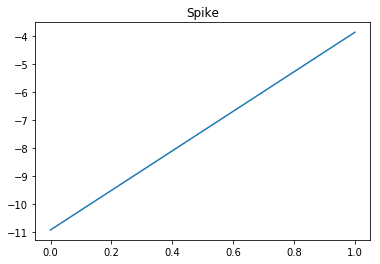

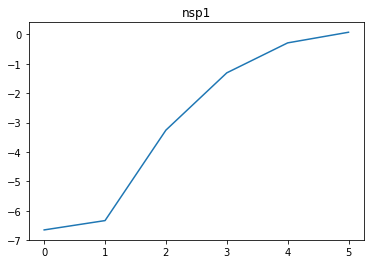

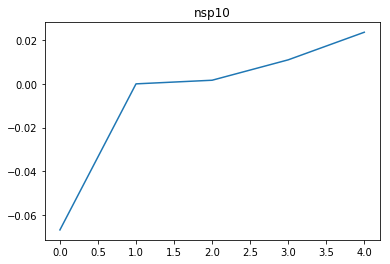

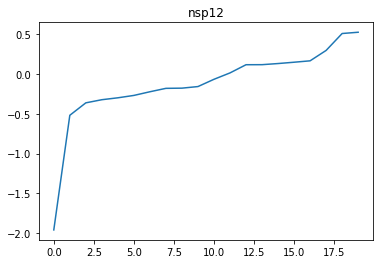

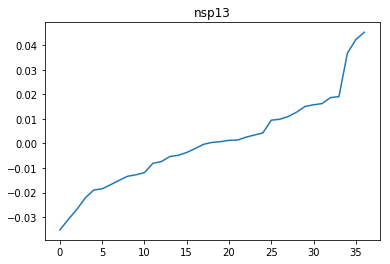

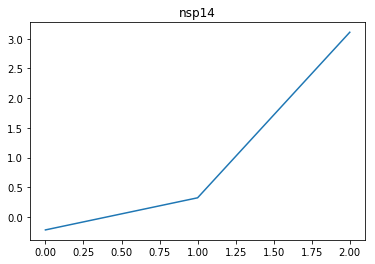

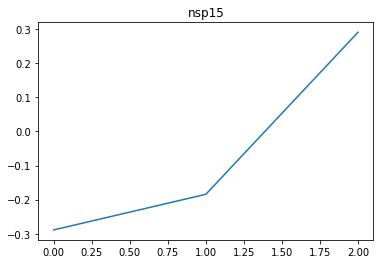

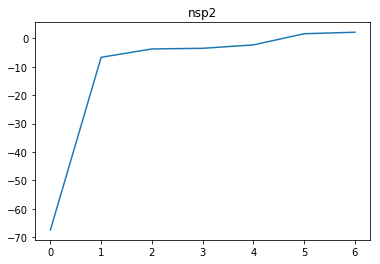

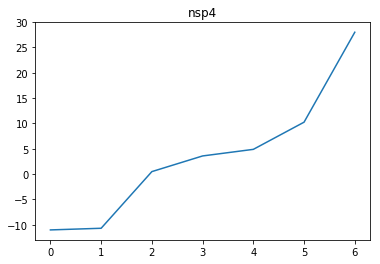

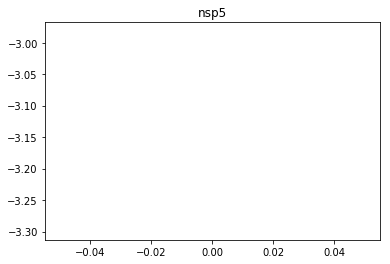

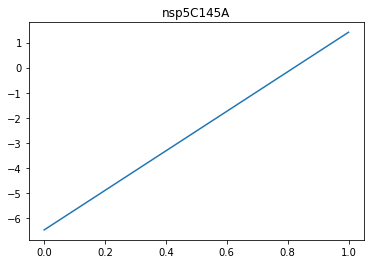

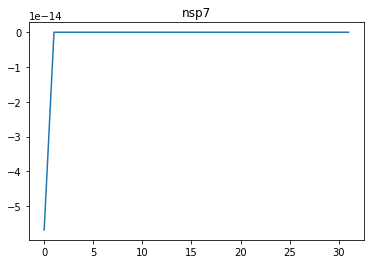

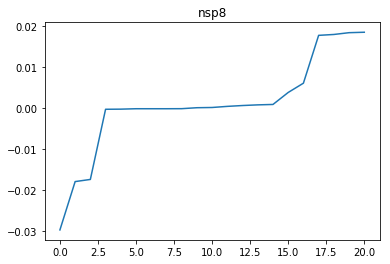

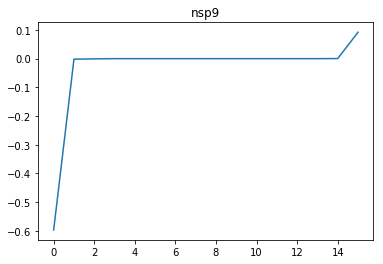

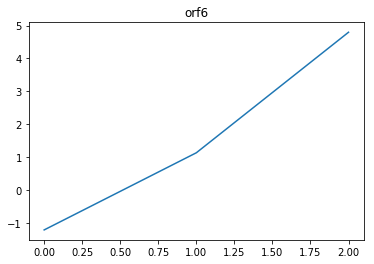

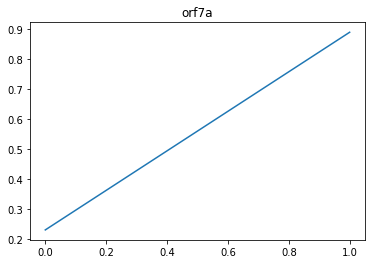

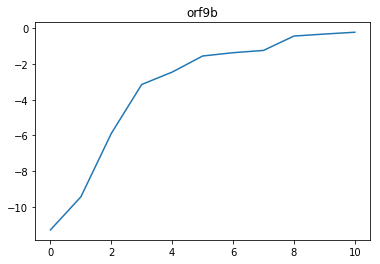

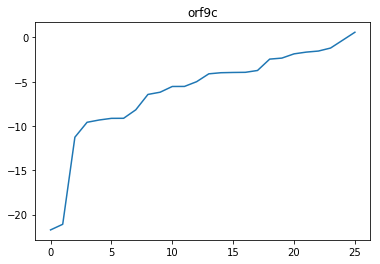

In [88]:
for g in ddG_summary.groupby("P1"):
    plt.plot(range(len(g[1])), sorted(g[1]["ddG"]))
    plt.title(g[0])
    plt.show()

(nsp2_COVID_SURFACE or O14975_COVID_SURFACE or nsp2_SARS_SURFACE or O14975_SARS_SURFACE)


In [98]:
tmp = inter2ddG[("orf9b_O94826")]
tmp[tmp["total"].map(lambda x: abs(x) > 0.1)]

,Chain,Res,Resi,fa_atr,fa_rep,fa_sol,hbond_bb_sc,hbond_sc,total
0,NA,NA,NA,1.815240,-10.605712,-1.462300,0.002785,-1.045044,-11.295140
4,A,LEU,14,0.025746,-0.020215,0.271126,-0.000000,-0.000000,0.276656
8,A,GLN,18,-0.187074,0.005134,0.517745,-0.000000,0.059446,0.395251
50,A,THR,60,0.081747,0.009930,-0.198190,0.000950,-0.000000,-0.105554
62,A,THR,72,-0.060515,-0.055951,0.612336,-0.000000,-0.149838,0.346031
65,A,ALA,75,0.363787,-1.968198,0.546283,-0.000000,-0.000000,-1.058143
66,A,VAL,76,-0.125554,-0.000702,0.305219,-0.000000,-0.000000,0.178966
67,A,GLN,77,-0.076399,-1.031971,-0.366592,-0.000000,-0.000000,-1.474958
77,A,LEU,87,0.063341,-0.010526,0.071068,-0.000000,-0.000000,0.123883
90,B,GLN,115,-0.124051,0.019685,0.952599,-0.000000,-0.000000,0.848236


In [99]:
tmp = inter2ddG[("nsp14_Q9NXA8")]
tmp[tmp["total"].map(lambda x: abs(x) > 0.1)]

,Chain,Res,Resi,fa_atr,fa_rep,fa_sol,hbond_bb_sc,hbond_sc,total
0,NA,NA,NA,-1.597800,3.193760,0.606200,-0.0426,0.948048,3.108040
140,A,PRO,140,0.051744,-0.132362,-0.063125,-0.0000,-0.000000,-0.143746
175,A,LYS,175,0.235493,-0.026526,-0.593513,-0.0000,-0.000000,-0.384546
176,A,ASN,176,-0.897542,1.621244,1.055810,-0.0000,0.438874,2.218385
228,A,HIS,228,-0.001911,-0.023888,-0.181895,-0.0000,-0.000000,-0.207698
299,A,ILE,299,-0.173464,0.097416,0.289405,-0.0000,-0.000000,0.213360
302,A,GLU,302,0.109670,-0.097993,-0.330224,-0.0000,-0.058332,-0.376879
406,A,LEU,406,-0.093309,-0.000000,-0.100110,-0.0000,-0.000000,-0.193419
407,A,SER,407,-0.098542,-0.000000,-0.067916,-0.0065,-0.000000,-0.172960
408,A,ASN,408,-0.141864,0.031162,0.492319,-0.0000,0.451383,0.833010


In [100]:
tmp = inter2ddG[("orf6_P52948")]
tmp[tmp["total"].map(lambda x: abs(x) > 0.1)]

,Chain,Res,Resi,fa_atr,fa_rep,fa_sol,hbond_bb_sc,hbond_sc,total
0,NA,NA,NA,-3.601760,4.043212,4.354840,-0.0,0.00001,4.796440
16,A,LEU,16,0.054558,-0.206256,0.031572,-0.0,-0.00000,-0.120107
23,A,LYS,23,0.251699,0.333369,0.698458,-0.0,-0.00000,1.283523
24,A,VAL,24,0.275619,0.338285,-0.453917,-0.0,-0.00000,0.160010
28,A,ASN,28,-0.061931,0.002669,-0.089581,-0.0,-0.00000,-0.148835
29,A,LEU,29,-0.406053,1.077418,-0.262295,-0.0,-0.00000,0.409067
30,A,ASP,30,0.168461,-0.003898,0.021554,-0.0,-0.00000,0.186130
31,A,TYR,31,-1.073786,0.454611,1.036047,-0.0,-0.00000,0.416875
34,A,ASN,34,-0.338430,0.071511,0.452416,-0.0,-0.00000,0.185487
37,A,ILE,37,-0.230788,0.001978,-0.018366,-0.0,-0.00000,-0.247181


In [102]:
tmp = inter2ddG[("orf9c_Q9Y3A6")]
tmp[tmp["total"].map(lambda x: abs(x) > 0.1)]

,Chain,Res,Resi,fa_atr,fa_rep,fa_sol,hbond_bb_sc,hbond_sc,total
0,NA,NA,NA,0.432700,-23.435200,2.227400,0.141248,-0.311733,-20.945400
3,A,GLN,3,-0.479691,-10.771141,1.096707,-0.000000,-0.000000,-10.154068
4,A,SER,4,0.235377,0.232800,0.133957,-0.000000,-0.000000,0.602135
6,A,TYR,6,0.468838,-0.399761,-0.370283,-0.000000,-0.000000,-0.301217
10,A,LYS,10,0.051709,0.000007,0.052342,-0.000000,-0.000000,0.104064
37,A,VAL,37,0.073610,-0.014185,0.173109,-0.000000,-0.000000,0.232546
55,A,LEU,55,0.037548,-0.717687,0.113822,-0.000000,-0.000000,-0.566324
56,A,GLU,56,-0.573521,0.017472,0.332645,-0.000000,-0.000000,-0.223400
57,A,TRP,57,0.083032,-0.812879,0.117969,-0.000000,-0.000000,-0.611881
58,A,LEU,58,0.012286,0.209238,0.057626,-0.000000,-0.000000,0.279162


In [103]:
tmp = inter2ddG[("orf9c_Q9Y375")]
tmp[tmp["total"].map(lambda x: abs(x) > 0.1)]

,Chain,Res,Resi,fa_atr,fa_rep,fa_sol,hbond_bb_sc,hbond_sc,total
0,NA,NA,NA,0.147000,-15.609200,-5.423300,-0.079065,-0.520603,-21.485100
1,A,MET,1,-0.061118,0.290212,0.004928,-0.039537,-0.000000,0.194483
4,A,SER,4,0.099567,-0.018114,-0.226153,-0.000000,-0.000000,-0.144701
6,A,TYR,6,-0.180415,0.351253,0.192426,-0.000000,-0.000000,0.363265
8,A,PHE,8,-0.074151,-0.123720,-0.135702,-0.000000,-0.000000,-0.333566
19,A,THR,19,-0.001884,0.113500,-0.004766,-0.000000,-0.000000,0.106870
22,A,GLY,22,0.053578,0.323207,0.120146,-0.000000,-0.000000,0.496942
23,A,ALA,23,0.031375,-0.000081,-0.139437,-0.000000,-0.000000,-0.108144
25,A,ALA,25,0.068854,-0.016830,0.174392,-0.000000,-0.000000,0.226408
32,A,VAL,32,0.061749,0.014641,0.158562,-0.000000,-0.000000,0.234954


In [75]:
ddg_df[["chain", "resi", "total"]]

,Chain,Res,Resi,fa_atr,fa_rep,fa_sol,hbond_bb_sc,hbond_sc,total
0,NA,NA,NA,-3.601760,4.043212,4.354840,-0.0,0.00001,4.796440
1,A,MET,1,-0.000000,-0.000000,-0.000000,-0.0,-0.00000,-0.000000
2,A,PHE,2,-0.000000,-0.000000,-0.000000,-0.0,-0.00000,-0.000000
3,A,HIS,3,-0.000000,-0.000000,-0.000000,-0.0,-0.00000,-0.000000
4,A,LEU,4,-0.000000,-0.000000,-0.000000,-0.0,-0.00000,-0.000000
5,A,VAL,5,-0.000000,-0.000000,-0.000000,-0.0,-0.00000,-0.000000
6,A,ASP,6,-0.000000,-0.000000,-0.000000,-0.0,-0.00000,-0.000000
7,A,PHE,7,-0.000000,-0.000000,-0.000000,-0.0,-0.00000,-0.000000
8,A,GLN,8,-0.000000,-0.000000,-0.000000,-0.0,-0.00000,-0.000000
9,A,VAL,9,-0.000000,-0.000000,-0.000000,-0.0,-0.00000,-0.000000


In [ ]:
    for chain, resi, delta in merged[["Chain", "Resi", "total"]].values:
        pymolCmd.color(matplotlib.colors.rgb2hex(cmapddG(delta)[:3]).replace("#", "0x"), "{0}_NearMut and chain {1} and resi {2}".format(mut, chain, resi))
    

[16, 17, 19, 20, 21, 22, 23, 24, 29, 30, 31, 32, 34, 35, 37, 39, 40, 44]

In [26]:
pdb_file

False

In [24]:
"{0:0.2f}".format(-23.5361)

'-23.54'

In [12]:
print p1 + "_COVID_Muts"
print p1 + "_COVID " + mut_sele

orf6_COVID_Muts
orf6_COVID and (resi 16 or resi 23 or resi 24 or resi 25 or resi 31 or resi 34 or resi 35 or resi 37 or resi 38 or resi 39 or resi 41 or resi 43 or resi 46 or resi 47 or resi 48 or resi 51 or resi 54 or resi 56 or resi 60)


In [ ]:
docked_struc

In [61]:
mut_sele

'and (resi 16 or resi 23 or resi 24 or resi 25 or resi 31 or resi 34 or resi 35 or resi 37 or resi 38 or resi 39 or resi 41 or resi 43 or resi 46 or resi 47 or resi 48 or resi 51 or resi 54 or resi 56 or resi 60)'

In [55]:
print pdb_file
print docked_struc

../../Data/ddG_Mutated_Structures/COVID19orf6_P52948_1_SARS_Muts_36Mut_Complex.pdb
../../Data/ddG_Mutated_Structures/COVID19orf6_P52948_1_SARS_Muts_36WT_Complex.pdb


In [ ]:
!ls ../../

In [2]:
import os
import sys
import glob

In [3]:
os.chdir("../../Data/ddG_Mutated_Structures/")

In [4]:
all_files = glob.glob("*.pdb")

In [14]:
0

0

In [23]:
sorted(all_files)[:10]

['COVID19Spike_Q7Z5G4_10_SARS_Muts_10Mut_Complex.pdb',
 'COVID19Spike_Q7Z5G4_10_SARS_Muts_10Mut_Separate.pdb',
 'COVID19Spike_Q7Z5G4_10_SARS_Muts_10WT_Complex.pdb',
 'COVID19Spike_Q7Z5G4_10_SARS_Muts_10WT_Separate.pdb',
 'COVID19Spike_Q7Z5G4_10_SARS_Muts_11Mut_Complex.pdb',
 'COVID19Spike_Q7Z5G4_10_SARS_Muts_11Mut_Separate.pdb',
 'COVID19Spike_Q7Z5G4_10_SARS_Muts_11WT_Complex.pdb',
 'COVID19Spike_Q7Z5G4_10_SARS_Muts_11WT_Separate.pdb',
 'COVID19Spike_Q7Z5G4_10_SARS_Muts_12Mut_Complex.pdb',
 'COVID19Spike_Q7Z5G4_10_SARS_Muts_12Mut_Separate.pdb']

In [16]:
len(all_files)

408080

In [19]:
0

0

In [20]:
0

0

# MISC - Disease Fractions

In [99]:
# HGMD Genes
a = 141
b = 191
c = 6620
d = 13398

exposure_mask = np.zeros(a + b + c + d)
case_mask = np.zeros(a + b + c + d)
exposure_mask[:a+b] = 1
case_mask[:a] = 1
case_mask[a+b:a+b+c] = 1

print "OR: {0} | UP: {1} | Low: {2} | p: {3}".format(*my.odds_ratio(exposure_mask, case_mask, log_odds=True, verbose=True))

print
print "Total:", len(exposure_mask)

n = a + b
p = a / float(a + b)
print "Exposed Ratio: {0:0.2f}  | SEM: {1}".format(100*p, 100*np.sqrt((p*(1-p))/n))

n = c + d
p = c / float(c + d)
print "Unexposed Ratio: {0:0.2f}  | SEM: {1}".format(100*p, 100*np.sqrt((p*(1-p))/n))


               Case  Non-Case
Exposed       141.0     191.0
Non-Exposed  6620.0   13398.0
OR: 0.579237059212 | UP: 0.896051504845 | Low: 0.262422613579 | p: 0.000339105991398

Total: 20350
Exposed Ratio: 42.47  | SEM: 2.71280835543
Unexposed Ratio: 33.07  | SEM: 0.332520139538


In [100]:
# ClinVar Genes
a = 106
b = 226
c = 4641
d = 15377

exposure_mask = np.zeros(a + b + c + d)
case_mask = np.zeros(a + b + c + d)
exposure_mask[:a+b] = 1
case_mask[:a] = 1
case_mask[a+b:a+b+c] = 1

print "OR: {0} | UP: {1} | Low: {2} | p: {3}".format(*my.odds_ratio(exposure_mask, case_mask, log_odds=True, verbose=True))

print
print "Total:", len(exposure_mask)

n = a + b
p = a / float(a + b)
print "Exposed Ratio: {0:0.2f}  | SEM: {1}".format(100*p, 100*np.sqrt((p*(1-p))/n))

n = c + d
p = c / float(c + d)
print "Unexposed Ratio: {0:0.2f}  | SEM: {1}".format(100*p, 100*np.sqrt((p*(1-p))/n))


               Case  Non-Case
Exposed       106.0     226.0
Non-Exposed  4641.0   15377.0
OR: 0.636007955422 | UP: 0.972237385804 | Low: 0.29977852504 | p: 0.000209359475847

Total: 20350
Exposed Ratio: 31.93  | SEM: 2.55858604391
Unexposed Ratio: 23.18  | SEM: 0.298270679792


In [316]:
# GWAS Genes
a = 48
b = 284
c = 1670
d = 20350 - (a + b + c)

exposure_mask = np.zeros(a + b + c + d)
case_mask = np.zeros(a + b + c + d)
exposure_mask[:a+b] = 1
case_mask[:a] = 1
case_mask[a+b:a+b+c] = 1

print "OR: {0} | UP: {1} | Low: {2} | p: {3}".format(*my.odds_ratio(exposure_mask, case_mask, log_odds=True, verbose=True, two_sided=False))

print
print "Total:", len(exposure_mask)

n = a + b
p = a / float(a + b)
print "Exposed Ratio: {0:0.2f}  | SEM: {1}".format(100*p, 100*np.sqrt((p*(1-p))/n))

n = c + d
p = c / float(c + d)
print "Unexposed Ratio: {0:0.2f}  | SEM: {1}".format(100*p, 100*np.sqrt((p*(1-p))/n))


               Case  Non-Case
Exposed        48.0     284.0
Non-Exposed  1670.0   18348.0
OR: 0.892918185937 | UP: 1.2681841961 | Low: 0.517652175776 | p: 4.54256397675e-05

Total: 20350
Exposed Ratio: 14.46  | SEM: 1.93006823487
Unexposed Ratio: 8.34  | SEM: 0.195443654159


In [317]:
# HGMD Ires Viral-Human
a = 63
b = 2659
c = 2164
d = 105789

exposure_mask = np.zeros(a + b + c + d)
case_mask = np.zeros(a + b + c + d)
exposure_mask[:a+b] = 1
case_mask[:a] = 1
case_mask[a+b:a+b+c] = 1

print "OR: {0} | UP: {1} | Low: {2} | p: {3}".format(*my.odds_ratio(exposure_mask, case_mask, log_odds=True, verbose=True, two_sided=False, error="SE"))

print
print "Total:", len(exposure_mask)

n = a + b
p = a / float(a + b)
print "Exposed Ratio: {0:0.2f}  | SEM: {1}".format(100*p, 100*np.sqrt((p*(1-p))/n))

n = c + d
p = c / float(c + d)
print "Unexposed Ratio: {0:0.2f}  | SEM: {1}".format(100*p, 100*np.sqrt((p*(1-p))/n))


               Case  Non-Case
Exposed        63.0    2659.0
Non-Exposed  2164.0  105789.0
OR: 0.211957175257 | UP: 0.398509733582 | Low: 0.0254046169321 | p: 0.127940743412

Total: 110675
Exposed Ratio: 2.31  | SEM: 0.288202180358
Unexposed Ratio: 2.00  | SEM: 0.0426576385883


In [323]:
# HGMD Ires Human-Human
a = 15731
b = 563140
c = 55399
d = 3505450

exposure_mask = np.zeros(a + b + c + d)
case_mask = np.zeros(a + b + c + d)
exposure_mask[:a+b] = 1
case_mask[:a] = 1
case_mask[a+b:a+b+c] = 1

print "OR: {0} | UP: {1} | Low: {2} | p: {3}".format(*my.odds_ratio(exposure_mask, case_mask, log_odds=True, verbose=True, two_sided=False, error="SE"))

print
print "Total:", len(exposure_mask)

n = a + b
p = a / float(a + b)
print "Exposed Ratio: {0:0.2f}  | SEM: {1}".format(100*p, 100*np.sqrt((p*(1-p))/n))

n = c + d
p = c / float(c + d)
print "Unexposed Ratio: {0:0.2f}  | SEM: {1}".format(100*p, 100*np.sqrt((p*(1-p))/n))


                Case   Non-Case
Exposed      15731.0   563140.0
Non-Exposed  55399.0  3505450.0
OR: 0.821784571782 | UP: 0.834981931273 | Low: 0.808587212291 | p: 0.0

Total: 4139720
Exposed Ratio: 2.72  | SEM: 0.0213704498512
Unexposed Ratio: 1.56  | SEM: 0.00655831866335


In [324]:
# ClinVar Ires Human-Viral
a = 64
b = 1972
c = 2611
d = 73341

exposure_mask = np.zeros(a + b + c + d)
case_mask = np.zeros(a + b + c + d)
exposure_mask[:a+b] = 1
case_mask[:a] = 1
case_mask[a+b:a+b+c] = 1

print "OR: {0} | UP: {1} | Low: {2} | p: {3}".format(*my.odds_ratio(exposure_mask, case_mask, log_odds=True, verbose=True, two_sided=False, error="SE"))

print
print "Total:", len(exposure_mask)

n = a + b
p = a / float(a + b)
print "Exposed Ratio: {0:0.2f}  | SEM: {1}".format(100*p, 100*np.sqrt((p*(1-p))/n))

n = c + d
p = c / float(c + d)
print "Unexposed Ratio: {0:0.2f}  | SEM: {1}".format(100*p, 100*np.sqrt((p*(1-p))/n))


               Case  Non-Case
Exposed        64.0    1972.0
Non-Exposed  2611.0   73341.0
OR: -0.1334982619 | UP: 0.0519805362577 | Low: -0.318977060058 | p: 0.23583963863

Total: 77988
Exposed Ratio: 3.14  | SEM: 0.386702323731
Unexposed Ratio: 3.44  | SEM: 0.0661101325583


In [325]:
# ClinVar Ires Human-Human
a = 16432
b = 412043
c = 71853
d = 2557905

exposure_mask = np.zeros(a + b + c + d)
case_mask = np.zeros(a + b + c + d)
exposure_mask[:a+b] = 1
case_mask[:a] = 1
case_mask[a+b:a+b+c] = 1

print "OR: {0} | UP: {1} | Low: {2} | p: {3}".format(*my.odds_ratio(exposure_mask, case_mask, log_odds=True, verbose=True, two_sided=False, error="SE"))

print
print "Total:", len(exposure_mask)

n = a + b
p = a / float(a + b)
print "Exposed Ratio: {0:0.2f}  | SEM: {1}".format(100*p, 100*np.sqrt((p*(1-p))/n))

n = c + d
p = c / float(c + d)
print "Unexposed Ratio: {0:0.2f}  | SEM: {1}".format(100*p, 100*np.sqrt((p*(1-p))/n))


                Case   Non-Case
Exposed      16432.0   412043.0
Non-Exposed  71853.0  2557905.0
OR: 0.505555570205 | UP: 0.51826374371 | Low: 0.492847396699 | p: 0.0

Total: 3058233
Exposed Ratio: 3.83  | SEM: 0.0293378478684
Unexposed Ratio: 2.73  | SEM: 0.0100528911632
